In [1]:
# library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import os
import re
import glob
import shutil
import gc
from pathlib import Path
from tqdm import tqdm
# showing module
from IPython.display import display
# matplotlib Japanese support
import japanize_matplotlib

# output display option adjustment
# precision of floating point in numpy
np.set_printoptions(suppress=True, precision=4)

# precision of floating point in pandas
pd.options.display.float_format = '{:.4f}'.format

# display all columns in dataframe
pd.set_option("display.max_columns",None)

# default font size in graph
plt.rcParams["font.size"] = 14

# graph display
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

# random seed
random_seed = 45

<Figure size 864x360 with 0 Axes>

In [22]:
# Timer display

# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

# データ管理環境整備

≒ディレクトリ整備

In [2]:
# # input_dir（input directory） を作る
current_note_path = os.path.dirname(os.path.abspath('__file__'))
INPUT_DIR = os.path.join(current_note_path, "data")

# INPUT_DIRがまだ作られていなければ作成
if not os.path.isdir(INPUT_DIR):
    os.mkdir(INPUT_DIR)

# output_dir(output directory) を作る
OUTPUT_DIR = os.path.join(current_note_path, 'outputs')

# OUTPUT_DIRがまだ作られていなければ作成
if not os.path.isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [4]:
# 1回やったらコメントアウトする
# # csvファイルを `data` ディレクトリ（=フォルダー） に移動させます
# unique_dir_names = []
# for f in Path(f'{current_note_path}').rglob('*.csv'):
#     unique_dir_names.append(f)

# for file in list(set(unique_dir_names)):
#     print(f'moved file: {file}')
#     shutil.move(f'{file}', f'{INPUT_DIR}')

moved file: /Users/satoshiido/Documents/coding_general/signate/三菱コンペ/submit_sample.csv
moved file: /Users/satoshiido/Documents/coding_general/signate/三菱コンペ/train.csv
moved file: /Users/satoshiido/Documents/coding_general/signate/三菱コンペ/test.csv


In [3]:
# csv(or any file)を簡単に読み込めるようにする関数
# csv を読み取る関数を設定したあげると、pathや拡張子を書かずに読み込めるので入力が楽になる

# 通常のcsvファイルを読み取るときは以下
def read_csv(name, **kwrgs):
    path = os.path.join(INPUT_DIR, name + '.csv')
    print(f'Load: {path}')
    return pd.read_csv(path, **kwrgs)

# データ読み込み

In [148]:
train = read_csv('train')
test = read_csv('test')
sample = read_csv('submit_sample')

Load: /Users/satoshiido/Documents/coding_general/signate/三菱コンペ/data/train.csv
Load: /Users/satoshiido/Documents/coding_general/signate/三菱コンペ/data/test.csv
Load: /Users/satoshiido/Documents/coding_general/signate/三菱コンペ/data/submit_sample.csv


In [149]:
# 以下のカラムは頻出で、毎回入力するのはめんどくさいので、ポップアップされるように定義します
y = 'y'
dateid ='dateid'

In [150]:
# dateidをdatetime valueに変換する（時間データは不要）
train[dateid] = pd.to_datetime(train[dateid], format='%Y-%m-%d')
test[dateid] = pd.to_datetime(test[dateid], format='%Y-%m-%d')

# EDA

In [108]:
# メモリを消費しているデータについて調べられる

import sys
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 1000:
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                       In|      1080|
|                    KFold|      1064|
|             LabelEncoder|      1064|
|            OneHotEncoder|      1064|
|                      Out|      1176|
|            ProfileReport|      1192|
|                    Timer|      1064|
|                date_only|      5904|
|                   sample|     10869|
|                     test|     53818|
|                     tqdm|      1064|
|                    train|    128774|
|            train_columns|      1075|


In [109]:
# ガベージコレクション
gc.collect()

8938

In [110]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dateid         337 non-null    datetime64[ns]
 1   y              337 non-null    float64       
 2   week           337 non-null    object        
 3   soldout        337 non-null    int64         
 4   name           337 non-null    object        
 5   kcal           304 non-null    float64       
 6   remarks        49 non-null     object        
 7   event          28 non-null     object        
 8   payday         17 non-null     float64       
 9   weather        337 non-null    object        
 10  precipitation  337 non-null    float64       
 11  temperature    337 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(5)
memory usage: 31.7+ KB


In [93]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dateid         144 non-null    datetime64[ns]
 1   week           144 non-null    object        
 2   soldout        144 non-null    int64         
 3   name           144 non-null    object        
 4   kcal           128 non-null    float64       
 5   remarks        16 non-null     object        
 6   event          14 non-null     object        
 7   payday         8 non-null      float64       
 8   weather        144 non-null    object        
 9   precipitation  144 non-null    float64       
 10  temperature    144 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 12.5+ KB


In [94]:
# dateidがid代わり（現状はカテゴリ変数になっているためtimestamp変数に変換する必要がある）
# yが予測対象
# nameとweatherの処理が大事そう
train.head()

,dateid,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2014-04-01,125.0000,Tue,1,メンチカツ,377.0000,NaN,NaN,NaN,晴時々薄曇,0.0000,13.9000
1,2014-04-02,99.0000,Wed,0,肉じゃが,380.0000,NaN,NaN,NaN,薄曇一時晴,0.0000,15.2000
2,2014-04-03,100.0000,Thu,1,酢豚,390.0000,NaN,NaN,NaN,大雨,65.0000,13.8000
3,2014-04-04,90.0000,Fri,1,和風ソースハンバーグ,350.0000,NaN,NaN,NaN,晴時々曇一時雨、雷を伴う,40.0000,15.3000
4,2014-04-07,107.0000,Mon,0,青梗菜牛肉炒め,387.0000,NaN,NaN,NaN,晴後一時薄曇,0.0000,11.4000


In [95]:
# datetimeのunique数
## dt.dateとは(https://pystyle.info/pandas-dt-accessor/)
date_only = train[dateid].dt.date
len(date_only.unique())

337

In [97]:
test.head()

,dateid,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2015-09-07,Mon,0,豚肉の柚子胡椒炒め,428.0000,NaN,NaN,NaN,雨時々曇,19.0000,23.0000
1,2015-09-08,Tue,0,鶏肉の塩麹焼き,420.0000,NaN,NaN,NaN,大雨,65.5000,20.0000
2,2015-09-09,Wed,0,サバの味醂干し焼き,456.0000,NaN,NaN,NaN,大雨、雷を伴う,156.5000,22.4000
3,2015-09-10,Thu,1,塩唐揚げ,439.0000,NaN,NaN,1.0000,雨一時曇,50.0000,21.8000
4,2015-09-11,Fri,0,カレーライス(ポークカレー),NaN,お楽しみメニュー,NaN,NaN,晴一時曇,0.0000,23.9000


In [111]:
# カテゴリカル変数のunique数
print('~~~~train data~~~~')
print(train['week'].value_counts())
print('~~~~~~~~')
print(train['remarks'].value_counts())
print('~~~~~~~~')
print(train['event'].value_counts())
print('~~~test data~~~~~')
print(test['week'].value_counts())
print('~~~~~~~~')
print(test['remarks'].value_counts())
print('~~~~~~~~')
# test dataとtrain dataに別のevent名がある-> label encodingではなく、frequency encodingをする
print(test['event'].value_counts())

~~~~train data~~~~
Thu    71
Wed    69
Tue    68
Fri    68
Mon    61
Name: week, dtype: int64
~~~~~~~~
お楽しみメニュー          28
料理長のこだわりメニュー       7
コンビニ改装             4
料理長イチオシ！           2
今月のイチオシ!           2
今月のこだわりメニュー        2
スペシャルメニュー          1
近隣に飲食店複合ビルオープン     1
料理長イチオシ!           1
弁当種類増↓             1
Name: remarks, dtype: int64
~~~~~~~~
ママの会             14
キャリアアップ支援セミナー    14
Name: event, dtype: int64
~~~test data~~~~~
Wed    30
Tue    29
Thu    29
Mon    28
Fri    28
Name: week, dtype: int64
~~~~~~~~
お楽しみメニュー       15
人気のおすすめメニュー     1
Name: remarks, dtype: int64
~~~~~~~~
ママの会             8
キャリアアップ支援セミナー    6
Name: event, dtype: int64


In [98]:
# datetimeのunique数
date_only = test[dateid].dt.date
len(date_only.unique())

144

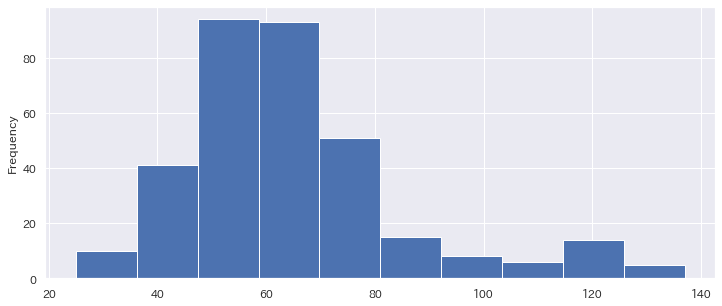

In [99]:
# 販売数としては50~70あたりが最頻値
train[y].astype(int).plot.hist();

In [142]:
# trainのweekごとの販売数の基本統計量を見てみる
## Fri が最も売れている
## Thu　は最も売れていない
train[[y, 'week']].groupby(by='week', as_index=False).agg(['count', 'mean', 'median', 'min', 'max', 'sum', 'var'])

y                                                     
     count    mean  median     min      max       sum       var
week                                                           
0       68 75.5441 64.0000 25.0000 137.0000 5137.0000 1270.0129
1       61 65.6393 65.0000 29.0000 109.0000 4004.0000  187.5011
2       71 56.7887 56.0000 32.0000 100.0000 4032.0000  159.7976
3       68 63.5441 62.0000 40.0000 125.0000 4321.0000  168.5204
4       69 64.8696 63.0000 44.0000 104.0000 4476.0000  174.9386

<b>Excelシートに出力する</b>

Excelなどで眺めて特徴をつかむ。今回はデータ数が少ないため全体を眺めることができる。\
サイズが大きいデータでも100行ぐらいを出力して眺めるので良い

エクセルを眺めてわかったこと
* remarksの"お楽しみメニュー"は販売数の多いカレーの日に着くことが多い->これはフラグを立てたカラムを作った方がよさそう
* ほとんどのカレーが金曜日に提供されている
* カレーでもキーマカレーなどは大して売れていない。カレーだからと言って販売数が多くなるかは怪しい

In [100]:
import openpyxl
if not os.path.isfile(os.path.join(OUTPUT_DIR, "train.xlsx")):
    train.to_excel(os.path.join(OUTPUT_DIR, "train.xlsx"))

if not os.path.isfile(os.path.join(OUTPUT_DIR, "test.xlsx")):
    test.to_excel(os.path.join(OUTPUT_DIR, "test.xlsx"))

<b>Pandas_Profiling</b>

EDAのための簡単なデータ要約をしてくれる\
データフレームの特徴を自動的に作ってくれる pandas-profiling を利用する方法もある\
しかしカラム数が多いデータの場合、ファイルサイズが大きくなり、表示失敗しやすくなるため注意

In [151]:
# https://qiita.com/wakame1367/items/39faf5d91e20a5cf5772#_reference-a12e589891bdd7bf36e5
from pandas_profiling import ProfileReport

# カラム数を取得
train_columns = train.columns
display(len(train_columns))
display(len(train))

12

337

In [152]:
# 要約を確認したいカラム数を選択する
report1 = ProfileReport(train[train_columns[1:]], missing_diagrams={
    'bar': False,
    'matrix': False,
    'heatmap': False,
    'dendrogram': False})

# OUTPUT ディレクトリーにhtmlファイル形式で保存
if not os.path.isfile(os.path.join(OUTPUT_DIR, "pandas_report_of_train_data.html")):
    report1.to_file(os.path.join(OUTPUT_DIR, "pandas_report_of_train_data.html"))

平日の販売数の周期を確認する\
見やすさのために2014-04 ~2014-8-08間をサンプルとして取得

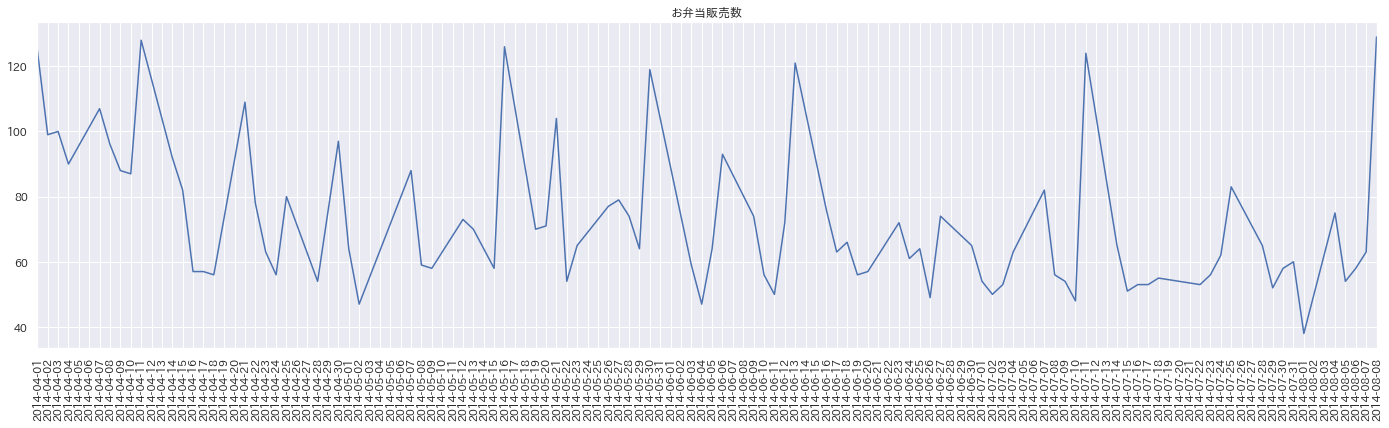

In [75]:
# 曜日による周期傾向はあまりない
# 四季、梅雨などによる影響は少なそう（ビジネスパーソンへの弁当販売とかなら別に季節関係ないから納得できる）
# カレーの売上が目立つ
# カレーの次の日の売上は多くの場合下がると考えられる

import matplotlib.dates as mdates

# plot the time-series graph (expenditure for icecream)
fig, ax = plt.subplots(figsize = (24, 6))

# graph plot
ax.plot(train[dateid].iloc[:90], train[y].iloc[:90], c = 'b')

# graph memory for 1-day periods
day1 = mdates.DayLocator(interval = 1)
ax.xaxis.set_major_locator(day1)

# rotation
ax.tick_params(axis = 'x', rotation = 90)

# start date and end date
sday = pd.to_datetime('2014-04-1')
eday = pd.to_datetime('2014-08-08')
ax.set_xlim(sday, eday)

# graph paper
ax.set_title('お弁当販売数')

# plot
plt.show()
ax.grid()

全範囲でのプロット

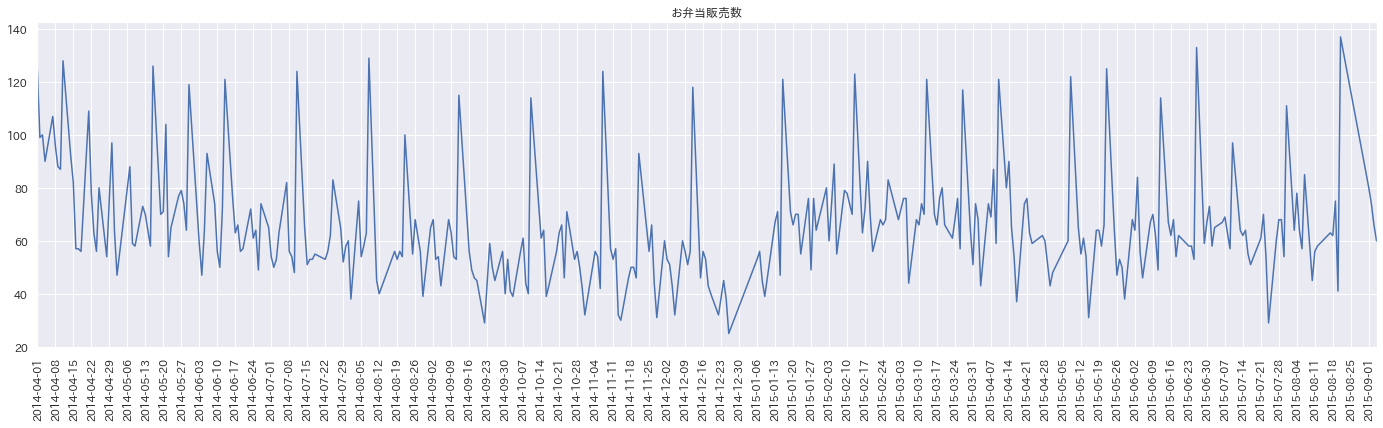

In [76]:
# plot the time-series graph (expenditure for icecream)
fig, ax = plt.subplots(figsize = (24, 6))

# graph plot
ax.plot(train[dateid], train[y], c = 'b')

# graph memory for 1-weekday periods
week1 = mdates.WeekdayLocator(interval = 1)
ax.xaxis.set_major_locator(week1)

# rotation
ax.tick_params(axis = 'x', rotation = 90)

# start date and end date
sday = pd.to_datetime('2014-04-1')
eday = pd.to_datetime('2015-09-04')
ax.set_xlim(sday, eday)

# graph paper
ax.set_title('お弁当販売数')

# plot
plt.show()
ax.grid()

# 前処理 + 特徴量エンジニアリング

ある程度データを理解したところで学習データ(=入力データ & 正解データ)を作っていく


* 欠損値処理
  * event, remarks カラムの欠損値はそのままにする
  * paydayの欠損値は0に置換
* カテゴリデータ
  * week, event は "label encoding"
  * remarks は"frequency encoding"
  * name はグルーピングする
* 前処理が終わったら相関性が強いデータのプロットをしてみる
  * https://www.kaggle.com/code/reisel/how-to-handle-correlated-features
* 集約して統計量をとる（3.9）
  * 平均・分散・最小・最大値は算出して組み込む
* 変数の組み合わせ（3.7）
* 学習後の特徴量の重要度を用いる（6.2.2）
* Light GBMといったGBDT系のモデルを使用する

In [154]:
# dataの再度読み込みなど出戻りを防ぐために複製する. train_xの方はstay remainで
train_x = train.copy()

## 前処理

### 欠損値処理

In [156]:
# paydayの欠損値補完
train['payday'] = train['payday'].fillna(0)
test['payday'] = test['payday'].fillna(0)

In [137]:
# kcalの欠損値補完
## カレーのkcalは欠損していないデータの平均で補完する（今回はデータが少ないので目視で手計算）
curry_kcal = [400, 420, 436, 445, 420, 405, 462, 436, 485]
curry_mean = round(np.mean(curry_kcal))

train['kcal'] = train['kcal'].fillna(curry_mean)
test['kcal'] = test['kcal'].fillna(curry_mean)

In [158]:
train[~train['kcal'].isnull()]

,dateid,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2014-04-01,125.0000,Tue,1,メンチカツ,377.0000,NaN,NaN,0.0000,晴時々薄曇,0.0000,13.9000
1,2014-04-02,99.0000,Wed,0,肉じゃが,380.0000,NaN,NaN,0.0000,薄曇一時晴,0.0000,15.2000
2,2014-04-03,100.0000,Thu,1,酢豚,390.0000,NaN,NaN,0.0000,大雨,65.0000,13.8000
3,2014-04-04,90.0000,Fri,1,和風ソースハンバーグ,350.0000,NaN,NaN,0.0000,晴時々曇一時雨、雷を伴う,40.0000,15.3000
4,2014-04-07,107.0000,Mon,0,青梗菜牛肉炒め,387.0000,NaN,NaN,0.0000,晴後一時薄曇,0.0000,11.4000
...,...,...,...,...,...,...,...,...,...,...,...,...
331,2015-08-20,41.0000,Thu,0,酢豚,418.0000,NaN,NaN,0.0000,雨後時々曇,8.0000,25.6000
333,2015-09-01,80.0000,Tue,1,自家製手作りトンカツ,423.0000,弁当種類増↓,NaN,0.0000,雨後曇、雷を伴う,12.0000,23.7000
334,2015-09-02,74.0000,Wed,0,チーズメンチカツ,463.0000,NaN,NaN,0.0000,曇時々雨後晴,5.5000,26.9000
335,2015-09-03,66.0000,Thu,1,鶏肉黒胡椒焼きおろしソース,420.0000,NaN,NaN,0.0000,曇後一時雨,1.5000,25.7000


In [161]:
curry_kcal = train[train['name'].str.contains('カレー')].kcal.mean()

425.4

In [198]:
lists = ['肉じゃが', 'カレー', 'コロッケ', 'トンカツ', 'メンチカツ', '唐揚げ', 'ステーキ']
for i in lists:
    display(train[train['name'].str.contains(i)])
    display(round(train[train['name'].str.contains(i)]['kcal'].mean()))

,dateid,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
1,2014-04-02,99.0000,Wed,0,肉じゃが,380.0000,NaN,NaN,0.0000,薄曇一時晴,0.0000,15.2000
23,2014-05-07,88.0000,Wed,1,肉じゃが,415.0000,NaN,NaN,0.0000,晴,0.0000,16.5000
322,2015-08-05,64.0000,Wed,1,肉じゃが,NaN,NaN,NaN,0.0000,快晴,0.0000,30.2000


398

,dateid,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
8,2014-04-11,128.0000,Fri,1,チキンカレー,NaN,お楽しみメニュー,NaN,0.0000,晴,0.0000,12.9000
30,2014-05-16,126.0000,Fri,0,ポークカレー,NaN,お楽しみメニュー,ママの会,0.0000,晴後一時雨,0.0000,21.5000
40,2014-05-30,119.0000,Fri,0,チキンカレー,NaN,お楽しみメニュー,NaN,0.0000,薄曇後晴,0.0000,24.1000
50,2014-06-13,121.0000,Fri,0,キーマカレー,NaN,お楽しみメニュー,NaN,0.0000,晴後一時雨、雷を伴う,1.5000,24.9000
70,2014-07-11,124.0000,Fri,0,ポークカレー,NaN,お楽しみメニュー,NaN,0.0000,曇時々晴,4.0000,28.5000
86,2014-08-05,54.0000,Tue,1,鶏肉のカレー唐揚,400.0000,NaN,NaN,0.0000,快晴,0.0000,31.1000
89,2014-08-08,129.0000,Fri,0,チキンカレー,NaN,お楽しみメニュー,NaN,1.0000,曇時々雨,0.0000,29.0000
98,2014-08-26,68.0000,Tue,0,キーマカレー,400.0000,NaN,NaN,0.0000,雨時々曇,0.0000,25.2000
111,2014-09-12,115.0000,Fri,0,ポークカレー,NaN,お楽しみメニュー,NaN,0.0000,晴後一時曇,0.0000,23.5000
127,2014-10-08,44.0000,Wed,0,完熟トマトのホットカレー,420.0000,NaN,NaN,0.0000,晴時々曇,0.0000,20.3000


425

,dateid,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
35,2014-05-23,65.0000,Fri,0,牛肉コロッケ,400.0000,NaN,NaN,0.0000,薄曇,0.0000,17.8000
184,2015-01-09,39.0000,Fri,0,牛肉コロッケ,415.0000,NaN,NaN,1.0000,快晴,0.0000,6.7000
230,2015-03-20,66.0000,Fri,0,炊き込みご飯・コロッケ,445.0000,NaN,ママの会,0.0000,曇,0.0000,11.8000
320,2015-08-03,64.0000,Mon,1,カニクリームコロッケ,NaN,NaN,NaN,0.0000,晴,0.0000,29.8000


420

,dateid,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
65,2014-07-04,63.0000,Fri,0,手作りトンカツ,432.0000,NaN,NaN,0.0000,雨時々曇,5.0000,21.6000
178,2014-12-24,45.0000,Wed,0,ジャンボトンカツ,460.0000,NaN,NaN,0.0000,薄曇後晴,0.0000,5.9000
263,2015-05-13,61.0000,Wed,0,手作りトンカツ,435.0000,NaN,NaN,0.0000,晴,0.0000,22.5000
284,2015-06-11,49.0000,Thu,0,自家製手作りトンカツ,455.0000,今月のイチオシ!,NaN,0.0000,薄曇,0.0000,23.0000
310,2015-07-17,51.0000,Fri,0,自家製手作りトンカツ,422.0000,今月のこだわりメニュー,ママの会,0.0000,曇一時雨,14.5000,26.7000
333,2015-09-01,80.0000,Tue,1,自家製手作りトンカツ,423.0000,弁当種類増↓,NaN,0.0000,雨後曇、雷を伴う,12.0000,23.7000


438

,dateid,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2014-04-01,125.0000,Tue,1,メンチカツ,377.0000,NaN,NaN,0.0000,晴時々薄曇,0.0000,13.9000
20,2014-04-30,97.0000,Wed,1,豚味噌メンチカツ,368.0000,NaN,NaN,0.0000,雨,27.0000,16.7000
24,2014-05-08,59.0000,Thu,0,メンチカツ,405.0000,NaN,NaN,0.0000,薄曇,0.0000,18.7000
28,2014-05-14,64.0000,Wed,1,メンチカツ,430.0000,NaN,NaN,0.0000,薄曇,0.0000,21.9000
82,2014-07-30,58.0000,Wed,0,メンチカツ,441.0000,NaN,NaN,0.0000,晴,0.0000,27.9000
92,2014-08-18,56.0000,Mon,0,洋食屋さんのメンチカツ,396.0000,NaN,NaN,0.0000,曇後晴,0.0000,29.1000
106,2014-09-05,43.0000,Fri,0,メンチカツ,380.0000,NaN,NaN,0.0000,曇時々晴,0.0000,27.8000
112,2014-09-16,56.0000,Tue,0,チーズメンチカツ,438.0000,NaN,NaN,0.0000,晴時々曇,0.0000,25.1000
122,2014-10-01,53.0000,Wed,1,メンチカツ,420.0000,NaN,NaN,0.0000,雨時々曇,5.0000,21.2000
169,2014-12-10,51.0000,Wed,1,和牛メンチカツ,428.0000,NaN,NaN,1.0000,薄曇,0.0000,7.3000


421

,dateid,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
7,2014-04-10,87.0000,Thu,0,鶏の唐揚げおろしソース,362.0000,NaN,NaN,1.0000,晴,0.0000,16.1000
11,2014-04-16,57.0000,Wed,0,カレイ唐揚げ野菜あんかけ,330.0000,NaN,NaN,0.0000,薄曇,0.0000,18.7000
27,2014-05-13,70.0000,Tue,1,白身魚唐揚げ野菜餡かけ,428.0000,NaN,NaN,0.0000,雨後曇一時晴,5.5000,19.3000
38,2014-05-28,74.0000,Wed,1,鶏の唐揚げおろしソース,414.0000,NaN,NaN,0.0000,薄曇,0.0000,22.7000
47,2014-06-10,56.0000,Tue,0,カレイ唐揚げ野菜餡かけ,426.0000,NaN,NaN,1.0000,曇,2.0000,23.5000
54,2014-06-19,56.0000,Thu,0,アジ唐揚げ南蛮ソース,430.0000,NaN,NaN,0.0000,晴,0.0000,24.8000
62,2014-07-01,54.0000,Tue,0,カレイ唐揚げ夏野菜あん,362.0000,NaN,NaN,0.0000,曇後晴,1.5000,25.3000
99,2014-08-27,62.0000,Wed,0,カレイの唐揚げ,410.0000,NaN,NaN,0.0000,雨後時々曇,5.0000,21.2000
114,2014-09-18,46.0000,Thu,0,カレイ唐揚げ 甘酢あん,395.0000,NaN,NaN,0.0000,曇,0.0000,22.3000
138,2014-10-24,71.0000,Fri,0,唐揚げ丼,NaN,お楽しみメニュー,NaN,0.0000,晴一時曇,0.0000,16.7000


413

,dateid,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
105,2014-09-04,54.0000,Thu,1,チキンステーキ・きのこソース,405.0000,NaN,NaN,0.0000,曇,0.0000,25.2000
236,2015-03-30,64.0000,Mon,0,チキンステーキ・ミートソース,450.0000,NaN,NaN,0.0000,快晴,0.0000,16.2000
330,2015-08-19,75.0000,Wed,1,チキンステーキ,NaN,お楽しみメニュー,NaN,0.0000,曇,0.0000,27.8000


428

In [214]:
# kcal
def kcal_change(df):
    # kcalがnull値ではないデータを取り出す
    df_nonull = df[~df['kcal'].isnull()]
    
    # 肉じゃが、カレー、コロッケ、トンカツ、メンチカツ、唐揚げ、ステーキの平均カロリーを取得する
    ## 丼もの、ロコモコ、ランチビュッフェ、ひやしたぬきうどん・炊き込みご飯はその他にデータがないため別に対応する必要あり
    ## 注意点：https://teratail.com/questions/229199
    lists = ['肉じゃが', 'カレー', 'コロッケ', 'トンカツ', 'メンチカツ', '唐揚げ', 'ステーキ']
    for i in lists:
        print("fill the null valu with calories of ", i)
        kcal = round(df_nonull[df_nonull['name'].str.contains(i)]['kcal'].mean())
        kcal_filled = df.loc[df['name'].str.contains(i)]['kcal'].fillna(kcal)
        
    return df1


In [215]:
train = kcal_change(train)
train

fill the null valu with calories of  肉じゃが
fill the null valu with calories of  カレー
fill the null valu with calories of  コロッケ
fill the null valu with calories of  トンカツ
fill the null valu with calories of  メンチカツ
fill the null valu with calories of  唐揚げ
fill the null valu with calories of  ステーキ


,dateid,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2014-04-01,125.0000,Tue,1,メンチカツ,377.0000,NaN,NaN,0.0000,晴時々薄曇,0.0000,13.9000
1,2014-04-02,99.0000,Wed,0,肉じゃが,380.0000,NaN,NaN,0.0000,薄曇一時晴,0.0000,15.2000
2,2014-04-03,100.0000,Thu,1,酢豚,390.0000,NaN,NaN,0.0000,大雨,65.0000,13.8000
3,2014-04-04,90.0000,Fri,1,和風ソースハンバーグ,350.0000,NaN,NaN,0.0000,晴時々曇一時雨、雷を伴う,40.0000,15.3000
4,2014-04-07,107.0000,Mon,0,青梗菜牛肉炒め,387.0000,NaN,NaN,0.0000,晴後一時薄曇,0.0000,11.4000
...,...,...,...,...,...,...,...,...,...,...,...,...
332,2015-08-21,137.0000,Fri,0,チキンカレー,NaN,お楽しみメニュー,NaN,0.0000,曇後一時雨,2.5000,26.0000
333,2015-09-01,80.0000,Tue,1,自家製手作りトンカツ,423.0000,弁当種類増↓,NaN,0.0000,雨後曇、雷を伴う,12.0000,23.7000
334,2015-09-02,74.0000,Wed,0,チーズメンチカツ,463.0000,NaN,NaN,0.0000,曇時々雨後晴,5.5000,26.9000
335,2015-09-03,66.0000,Thu,1,鶏肉黒胡椒焼きおろしソース,420.0000,NaN,NaN,0.0000,曇後一時雨,1.5000,25.7000


In [205]:
def fill_kcal(x):
    x.loc[x['name'].str.contains('カレー')].fillna({'kcal': kcal})

train.apply(fill_kcal, axis=1)

AttributeError: 'str' object has no attribute 'str'

In [196]:
a = train[~train['kcal'].isnull()]
lists = ['肉じゃが', 'カレー', 'コロッケ', 'トンカツ', 'メンチカツ', '唐揚げ', 'ステーキ']
for i in lists:
    kcal = round(a[a['name'].str.contains(i)]['kcal'].mean())
    print(kcal)
    train.loc[train['name'].str.contains(i)].fillna({'kcal': kcal})
    #train[train['name'].str.contains(i)].fillna({'kcal': kcal})
    #train[train['name'].str.contains(i)]['kcal'].fillna(kcal)


398
425
420
438
421
413
428


### カテゴリカル変数の処理

In [112]:
# カテゴリカル変数のリストを作成
# 'name', 'weather'は保留、# 'remarks'はfrequency encodingをする
cat_col = ['week', 'event']

In [120]:
# 曜日をlabelencodingする
## 曜日の前後の情報を含めた特徴量生成も後でする
## remarksはtarget encodingできるかも
from sklearn.preprocessing import LabelEncoder
for c in cat_col:
    # LabelEncoderを宣言する
    le = LabelEncoder()
    # ラベルとラベルIDの対応づけを行う。positiveは0にしよう，みたいなことを決める
    le.fit(train[c].fillna('NaN'))
    # 学習データとテストデータそれぞれのdf内のカラムを変換する
    train[c] = le.transform(train[c].fillna('NaN'))
    test[c] = le.transform(test[c].fillna('NaN'))

In [121]:
# remarksカラムをfrequency encodingする
# train data に関して
freq_train = train['remarks'].value_counts()
## カテゴリの出現回数で置換する
train['remarks'] = train['remarks'].map(freq_train)

# test dataに関して
freq_test = test['remarks'].value_counts()
test['remarks'] = test['remarks'].map(freq_test)

In [35]:
train['weather'].value_counts()

晴                 51
快晴                32
曇                 23
薄曇                22
曇時々雨              13
                  ..
曇一時晴後時々雨           1
晴後一時雨、雷を伴う         1
晴後一時雨、雷・ひょうを伴う     1
雨後曇一時晴             1
曇時々雨後晴             1
Name: weather, Length: 62, dtype: int64
